<a href="https://colab.research.google.com/github/els285/Aachen_Intro2NN/blob/main/Exercises/4_Classification_Penguins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying our penguins

We now look at a quick classification problem with the penguin dataset, as a precursor to the main DNN exercise...

# Quick Visualisation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [ ]:
!wget -O penguins_downloaded.csv "https://cernbox.cern.ch/s/wh34GhKCOv0Umh7/download"
print("Download complete")

In [ ]:
input_penguins_df = pd.read_csv("penguins_downloaded.csv")
penguins_df = input_penguins_df.dropna(inplace=False)

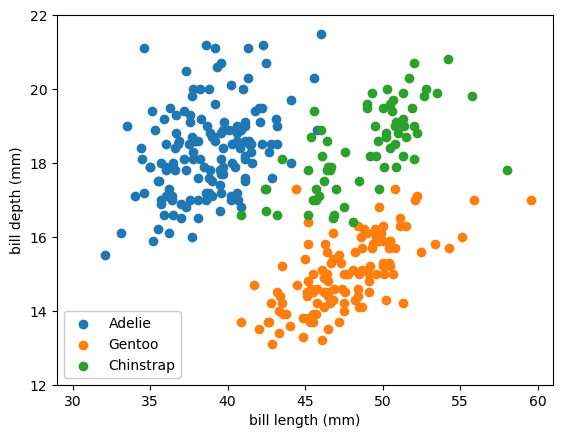

In [ ]:
fig, ax = plt.subplots()

def plot_categorical_problem(ax, xlow=29, xhigh=61, ylow=12, yhigh=22):
    # Create 3 separate dataframes, one for each species. We use the target array as a mask
    df_Adelie = penguins_df[penguins_df["species"] == "Adelie"]
    df_Gentoo = penguins_df[penguins_df["species"] == "Gentoo"]
    df_Chinstrap = penguins_df[penguins_df["species"] == "Chinstrap"]

    # Plot each species separately with individual colour
    ax.scatter(df_Adelie["bill_length_mm"], df_Adelie["bill_depth_mm"], color="tab:blue", label="Adelie")
    ax.scatter(df_Gentoo["bill_length_mm"], df_Gentoo["bill_depth_mm"], color="tab:orange", label="Gentoo")
    ax.scatter(df_Chinstrap["bill_length_mm"], df_Chinstrap["bill_depth_mm"], color="tab:green", label="Chinstrap")

    # Set plot parameters - less important
    ax.set_xlim(xlow, xhigh)
    ax.set_ylim(ylow, yhigh)
    ax.set_xlabel("bill length (mm)")
    ax.set_ylabel("bill depth (mm)")

    ax.legend(loc="lower left", framealpha=1)

plot_categorical_problem(ax)

plt.show()

The three species show reasonable separation... this should be be simple for the methods we've looked at

# Aim

We will write a binary classifier to classify the Adelie and Chinstrap penguins. Binary classification is easier to understand given what we've learned, and will stand us in good stead for the main task for the two DNN lectures.

If you want to classify the three species, this is **multiclass classification**. There are a couple of subtleties to this problem, including PyTorch syntax which hides away some details, making it less useful for learning. But if you're bored and feeling ambitious, you can try this at the end.

Note: I trained a binary classifier for separating Adelie from Gentoo, but the classes essentially too separable, leading to very low losses and making it not a great pedagogical example

# Pre-task

The only complexity is that the classification model we're about to define (and indeed all statistical /  machine learning models) can only deal with numerical data, so we need to convert the three species into unique numerical information.

For example, we could assign Adelie=0 and Chinstrap=1. These numbers have no real meaning, they're just necessary numerical placeholders for the species names. Our final model will output will be single score (though there are other ways to do this). We will map this score to a either a 0 or 1, classifying a datapoint as either Adelie or Chinstrap...

## To do:
* Define a new dataframe with only the Adelie and Chinstrap species included
* Define an array called `target` which is 0 for Adelie and 1 for Chinstrap. Hint, look up some pandas functionality if you a Python one-liner...

In [ ]:
penguins_df_no_gentoo = penguins_df[penguins_df["species"] != "Gentoo"]
target, species_names = pd.factorize(penguins_df_no_gentoo["species"])

In [ ]:
target = []
for species in penguins_df_no_gentoo["species"]:
    if species == "Adelie":
        target.append(0)
    else:
        target.append(1)

target = np.array(target)


In [ ]:
target, species_names = pd.factorize(penguins_df_no_gentoo["species"])

# Minimal Scikit-Learn LogisticRegression Example

A very minimal scikit-learn example, just to show you how easy it is...

Note that this gives two scores, with the higher indicating the correct class

You could also implement logistic regression using one linear layer plus a sigmoid in PyTorch of course...

In [ ]:
X = penguins_df_no_gentoo[["bill_length_mm", "bill_depth_mm"]].values
y_true = target

from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
best_fit = model.fit(X, y_true)

In [ ]:
random_datapoint_features = X[60].reshape(-1,2) # It needs to be reshaped because it's a single sample
random_datapoint_probabilities = best_fit.predict_proba(random_datapoint_features)
print(random_datapoint_probabilities)

[[9.99446623e-01 5.53377353e-04]]


# Main Task

1. Using what we learned in the previous exercise, build and train a DNN which takes in whatever inputs, and outputs a **single score**. Which final layer activation function, and which loss function, should we use?

2. Evaluate the model on the same dataset we trained on (bad practice but for this toy example it's fine). What are the outputs, and what do they represent? Map these outputs to the corresponding class label. It may help to plot the outputs as a histogram e.g. `plt.hist(y_out)` - make sure `y_out` is a numpy array

3. Present a set of metrics for evaluating binary classifier model performance. How many times does the model get it right and wrong? Use [scikit-learn classification metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)

### Things to note
* Make sure your target tensor, `y_true` or whatever you call it, is of shape Nx1 i.e. a column vector of floats

In [ ]:
X = penguins_df_no_gentoo[["bill_length_mm", "bill_depth_mm"]].values
X_tensor = torch.tensor(X, dtype=torch.float32)

y = target.reshape(-1, 1) # It needs to be a column vector
y_true_tensor = torch.tensor(y, dtype=torch.float32)

In [ ]:
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(2, 16),
    nn.Sigmoid(),
    nn.Linear(16, 1),
    nn.Sigmoid()
)
loss = nn.BCELoss()
optimizer = torch.optim.Rprop(model.parameters(), lr=0.1)

In [ ]:
# Training loop
losses = []
for i in range(250):
    # Forward pass
    y_pred = model(X_tensor)

    # Compute loss
    loss_value = loss(y_pred, y_true_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss_value.backward()
    optimizer.step()

    losses.append(loss_value.item())

    if i % 10 == 0:
        print(f"Epoch {i}, Loss: {loss_value.item()}")


Epoch 0, Loss: 0.7614383101463318
Epoch 10, Loss: 0.4449275732040405
Epoch 20, Loss: 0.6585221290588379
Epoch 30, Loss: 0.13146710395812988
Epoch 40, Loss: 0.12205696105957031
Epoch 50, Loss: 0.08640840649604797
Epoch 60, Loss: 0.05330534651875496
Epoch 70, Loss: 0.05044569447636604
Epoch 80, Loss: 0.048842523247003555
Epoch 90, Loss: 0.04771197959780693
Epoch 100, Loss: 0.04693569615483284
Epoch 110, Loss: 0.04666449502110481
Epoch 120, Loss: 0.04625196382403374
Epoch 130, Loss: 0.04580306634306908
Epoch 140, Loss: 0.045669782906770706
Epoch 150, Loss: 0.04556916281580925
Epoch 160, Loss: 0.04539201036095619
Epoch 170, Loss: 0.04510066658258438
Epoch 180, Loss: 0.04475053772330284
Epoch 190, Loss: 0.044479433447122574
Epoch 200, Loss: 0.04427777975797653
Epoch 210, Loss: 0.04413740336894989
Epoch 220, Loss: 0.044036880135536194
Epoch 230, Loss: 0.04397158324718475
Epoch 240, Loss: 0.04392972216010094


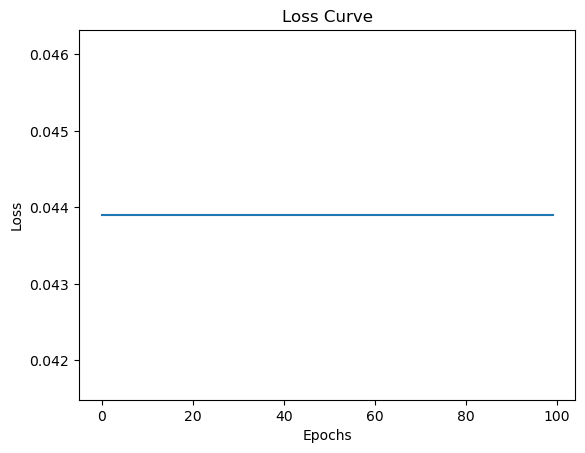

In [ ]:
def plot_loss_curve(losses):
    plt.plot(losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # plt.yscale('log')
    plt.title('Loss Curve')
    plt.show()

plot_loss_curve(losses)

(array([141.,   1.,   1.,   1.,   2.,   0.,   3.,   1.,   3.,  61.]),
 array([1.75004244e-13, 9.99985561e-02, 1.99997112e-01, 2.99995661e-01,
        3.99994224e-01, 4.99992788e-01, 5.99991322e-01, 6.99989915e-01,
        7.99988449e-01, 8.99987042e-01, 9.99985576e-01]),
 <BarContainer object of 10 artists>)

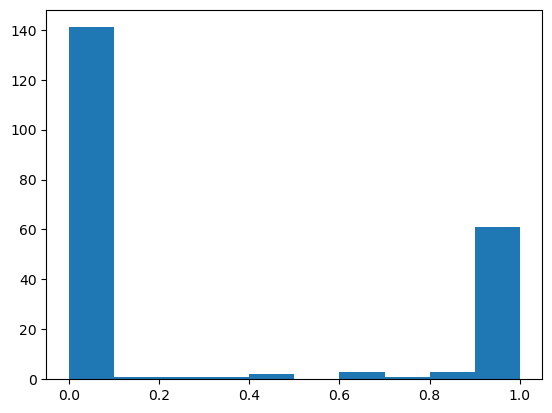

In [ ]:
y_pred = model(X_tensor)
plt.hist(y_pred.detach().numpy())


In [ ]:
y_final = y_pred.detach().numpy()
predicted_class = np.round(y_final)

In [ ]:
np.count_nonzero(y!=predicted_class)

6

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(target, predicted_class)
print(accuracy)

0.9719626168224299


In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(target, predicted_class)
print(conf_matrix)

[[143   3]
 [  3  65]]


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(target, predicted_class, average='weighted')
recall = recall_score(target, predicted_class, average='weighted')
f1 = f1_score(target, predicted_class, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.9719626168224299
Recall: 0.9719626168224299
F1 Score: 0.9719626168224299


# Multiclass Classification

Write a multiclass classifier for the whole dataset i.e. all three species. For this, we can use an **output layer with 3 nodes** (one for each class), and **no final layer activation function**. We can then use the `nn.CrossEntropyLoss` loss function. This is the preferred way to do multiclass classification in PyTorch.

In [ ]:
input_multiclass = penguins_df[["bill_length_mm", "bill_depth_mm"]].values
input_multiclass_tensor = torch.tensor(input_multiclass, dtype=torch.float32)

In [ ]:
target = pd.factorize(penguins_df["species"])[0]
y_multiclass_tensor = torch.tensor(target, dtype=torch.long)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

multiclass_model = nn.Sequential(
    nn.Linear(2, 16),
    nn.ReLU(),
    nn.Linear(16, 3)
)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Rprop(multiclass_model.parameters(), lr=0.01)


In [ ]:
# training loop with losses
losses = []

for epoch in range(200):
    # Forward pass: outputs are raw logits
    logits = multiclass_model(input_multiclass_tensor)

    loss_value = loss_function(logits, y_multiclass_tensor)

    optimizer.zero_grad()
    loss_value.backward()
    optimizer.step()

    losses.append(loss_value.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value.item()}")


Epoch 0, Loss: 4.174306392669678
Epoch 10, Loss: 1.1241754293441772
Epoch 20, Loss: 0.5180947780609131
Epoch 30, Loss: 0.3253246247768402
Epoch 40, Loss: 0.2186335027217865
Epoch 50, Loss: 0.19101941585540771
Epoch 60, Loss: 0.15791089832782745
Epoch 70, Loss: 0.13960139453411102
Epoch 80, Loss: 0.12091545760631561
Epoch 90, Loss: 0.11801039427518845
Epoch 100, Loss: 0.11643572151660919
Epoch 110, Loss: 0.1123010665178299
Epoch 120, Loss: 0.11061917245388031
Epoch 130, Loss: 0.10831886529922485
Epoch 140, Loss: 0.105970099568367
Epoch 150, Loss: 0.10413169115781784
Epoch 160, Loss: 0.10289257764816284
Epoch 170, Loss: 0.10125128924846649
Epoch 180, Loss: 0.0978277176618576
Epoch 190, Loss: 0.09335744380950928


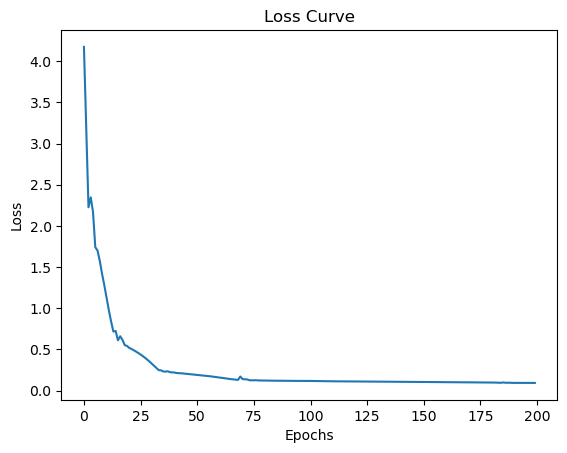

In [ ]:
plot_loss_curve(losses)

In [ ]:
y_out_tensor = multiclass_model(input_multiclass_tensor)

In [ ]:
probabilties = F.softmax(y_out_tensor,dim=1)

In [ ]:
y_out = y_out_tensor.detach().numpy()

In [ ]:
predicitons = np.argmax(y_out,axis=1)

You could also use a one-hot encoding apply the softmax manually, but this is less memory-efficient and more prone to numerical instability.